We hypothesise that bitcoin volatility dynamics exhibit regimes. This is supported by Ardia et al., 2018, who found that a two-regime model outperformed single and 3 regime models. 

In the group project, we found that HAR and RF models significantly outperformed GARCH and deep learning models in forecasting ETH volatility. Drawing from that conclusion, I want to implement a two-regime model to separately capture the dynamics of high and low unconditional Bitcoin volatility regimes, by training either HAR or RF models in either regime. 

Additionally, I want to incorporate volatility jump components in the markov-switching decision process. 

I will evaluate and compare the performances of a two-regime HAR, two-regime RF, two-regime HAR/RF, and their one-regime counterparts as baselines. Lastly, I will attempt to interpret feature importances in both regimes.

## Splitting Train Test set
- Note that for two regimes we cannot split chronologically as the distribution of High and Low volatility regime periods is not uniform. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np

data = pd.read_csv('../data/btcusd_lasso_selected.csv')
data['date'] = pd.to_datetime(data['time'])
data = data.drop(columns=['time', 'Fear_Greed_Classification'])
data.set_index('date', inplace=True)

#create target as one day leading
data['target'] = data['ln_RV_d,t'].shift(-1)
data = data.dropna()

## Markov Regime Classification

- Gaussian Hidden Markov Model (HMM)

### Should we train the GHMM over the entire set? Or should we train on training set only and then predict on both sets?

Train on training set only:
- Trained on the training set only to avoid look-ahead bias.
- Predicts regimes for both training and test sets to enable out-of-sample classification.

Classify regimes over the entire dataset first:
- The goal of an HMM is to infer hidden regimes that represent different volatility states in the market.
- These regimes are not dependent on future data in the way that predictive models are.

The following code uses forward filtering to compute the state probabilities at time t using observations only up to t.
This approach does not use future data when making the current state estimate.

The initial step computes the probability of being in each state at time 1 using the initial state distribution and the likelihood of the first observation.

The recursive step updates these probabilities for each subsequent observation using the transition matrix and the emission probabilities, followed by normalization.

The result is a time series of probability distributions over the states, computed in a forward (causal) manner, meaning that at each time t, only observations up to t are used.

State Means (log scale):
 Filtered_State
0   -6.262511
1   -7.434576
Name: ln_RV_d,t, dtype: float64


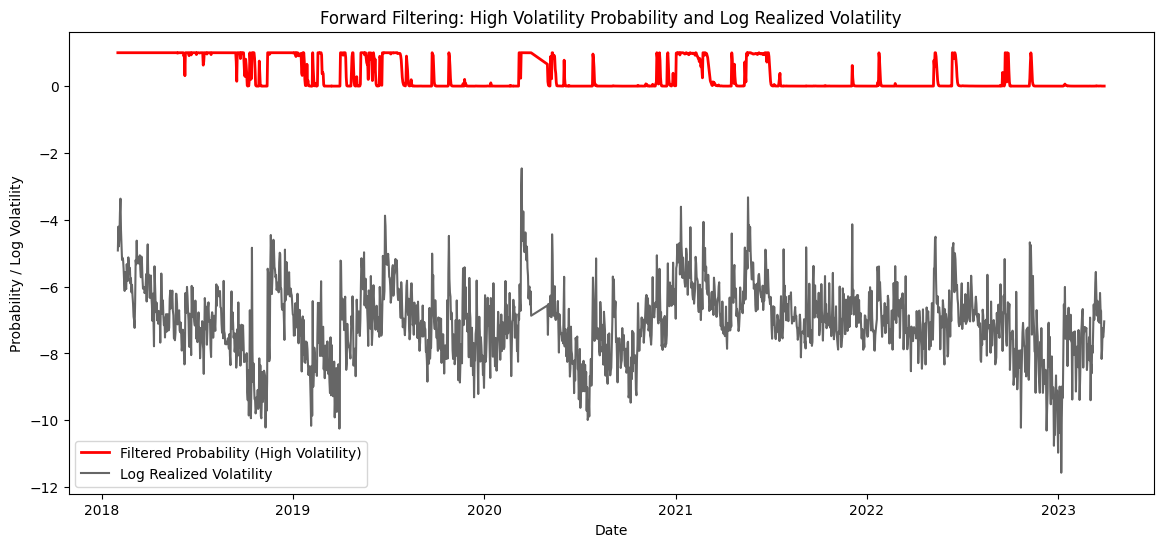

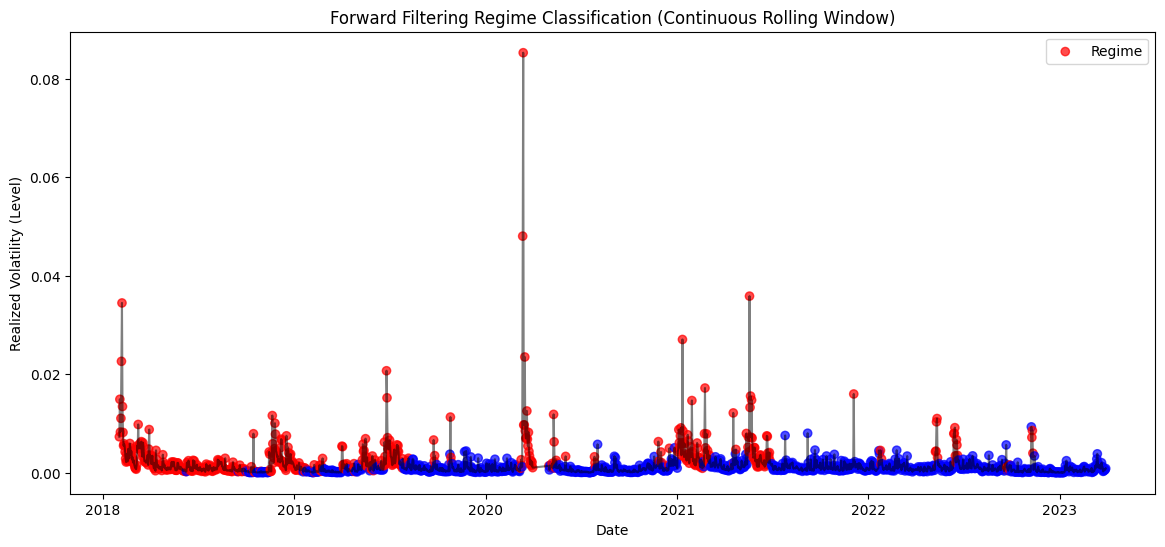

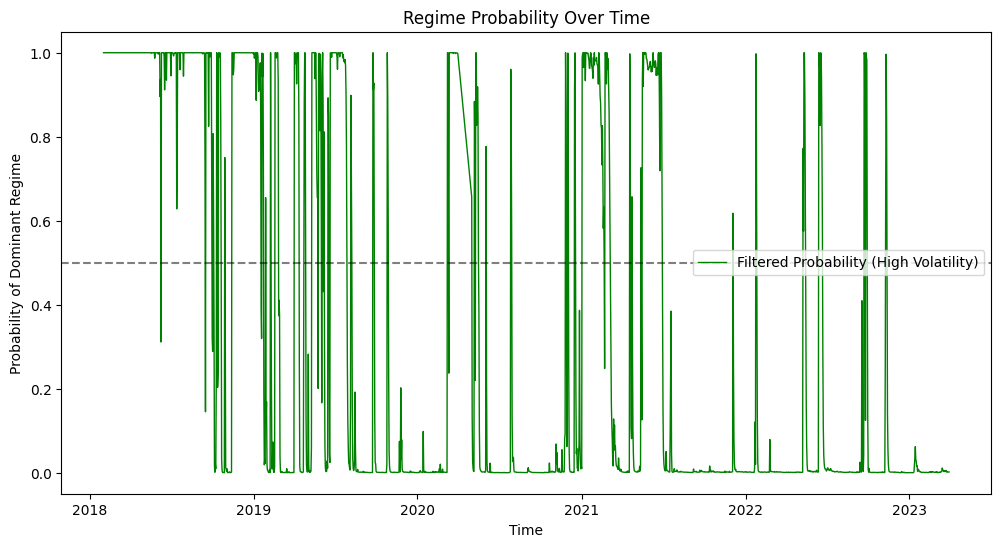

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# ------------------------------
# 1. Load and Prepare Data
# ------------------------------
# We'll use these features for the HMM:
features = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'volume']

# Scale the features using only the training period if desired.
# Here, since we are doing forward filtering on the entire dataset, we fit the scaler on the full data.
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# ------------------------------
# 2. Fit an HMM on the Entire Dataset
# ------------------------------
n_states = 2  # We assume two regimes
# We set init_params='' to avoid re-initialization when we call fit()
hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", 
                        n_iter=1000, init_params='', params="stmc", random_state=1)
hmm_model.fit(data_scaled)

# ------------------------------
# 3. Implement Forward Filtering
# ------------------------------
def forward_filtering(X, model):
    """
    Compute forward filtered probabilities for each time t,
    using the model's parameters (startprob, transmat, means, covars)
    and the observation sequence X (shape: T x n_features).
    
    Returns:
        alpha: an array of shape (T, n_states) where each row t
               contains the filtered state probabilities p(s_t | x_1,...,x_t).
    """
    T = X.shape[0]
    n_states = model.n_components
    alpha = np.zeros((T, n_states))
    
    # Initial step: compute emission probabilities for the first observation
    for j in range(n_states):
        pdf_val = multivariate_normal.pdf(X[0], mean=model.means_[j], cov=model.covars_[j])
        alpha[0, j] = model.startprob_[j] * pdf_val
    # Normalize alpha[0]
    alpha[0] /= np.sum(alpha[0])
    
    # Recursion: for t = 1 to T-1
    for t in range(1, T):
        for j in range(n_states):
            pdf_val = multivariate_normal.pdf(X[t], mean=model.means_[j], cov=model.covars_[j])
            alpha[t, j] = pdf_val * np.sum(alpha[t-1] * model.transmat_[:, j])
        # Normalize to avoid underflow
        alpha[t] /= np.sum(alpha[t])
    
    return alpha

# Compute forward filtered probabilities for the entire dataset
alpha = forward_filtering(data_scaled, hmm_model)

# Assign the filtered state as the state with the highest probability at each time t
filtered_states = np.argmax(alpha, axis=1)
data['Filtered_State'] = filtered_states

# ------------------------------
# 4. Map Filtered States to Regimes
# ------------------------------
# Determine which state corresponds to high volatility using the log-volatility feature.
# Here we use 'ln_RV_d,t' (log daily realized volatility).
state_means = data.groupby('Filtered_State')['ln_RV_d,t'].mean()
print("State Means (log scale):\n", state_means)

# Assume the state with the higher average log-volatility is "High Volatility"
high_state = state_means.idxmax()
low_state = state_means.idxmin()

def map_state(state):
    return 'High Volatility' if state == high_state else 'Low Volatility'

data['Regime'] = data['Filtered_State'].apply(map_state)

# ------------------------------
# 5. Plot the Forward Filtering Results
# ------------------------------

# Plot the filtered probability of the "High Volatility" state over time
plt.figure(figsize=(14,6))
plt.plot(data.index, alpha[:, high_state], label='Filtered Probability (High Volatility)', color='red', linewidth=2)
plt.plot(data.index, data['ln_RV_d,t'], label='Log Realized Volatility', color='black', alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Probability / Log Volatility")
plt.title("Forward Filtering: High Volatility Probability and Log Realized Volatility")
plt.legend()
plt.show()

# Plot realized volatility (converted to level) colored by regime
plt.figure(figsize=(14,6))
colors = data['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
plt.scatter(data.index, np.exp(data['ln_RV_d,t']), c=colors, label='Regime', alpha=0.7)
plt.plot(data.index, np.exp(data['ln_RV_d,t']), color='black', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Realized Volatility (Level)")
plt.title("Forward Filtering Regime Classification (Continuous Rolling Window)")
plt.legend()
plt.show()

# Plot regime probabilities
plt.figure(figsize=(12,6))
plt.plot(data.index, alpha[:, high_state], label='Filtered Probability (High Volatility)', color='green', linewidth=1)
#plt.plot(data.index, data['Regime_Prob'], label='Regime Probability', color='blue', alpha=0.7)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.title("Regime Probability Over Time")
plt.xlabel("Time")
plt.ylabel("Probability of Dominant Regime")
plt.show()


The following code trains the HMM on the entire dataset and then uses hmm.predict and hmm.predict_proba on the entire data. These functions perform a smoothing operation over the full sequence—that is, they use both past and future observations to assign the most likely state at each time step.

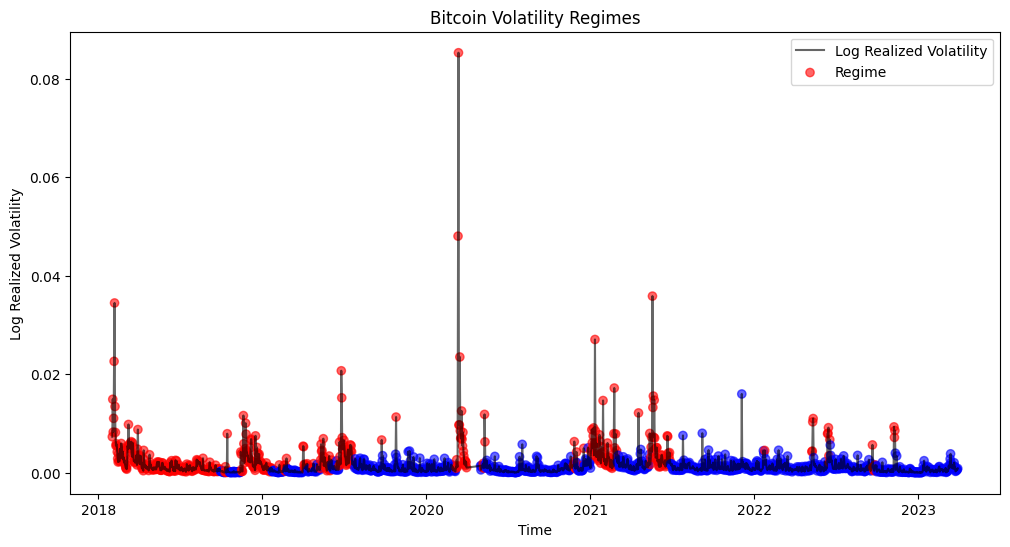

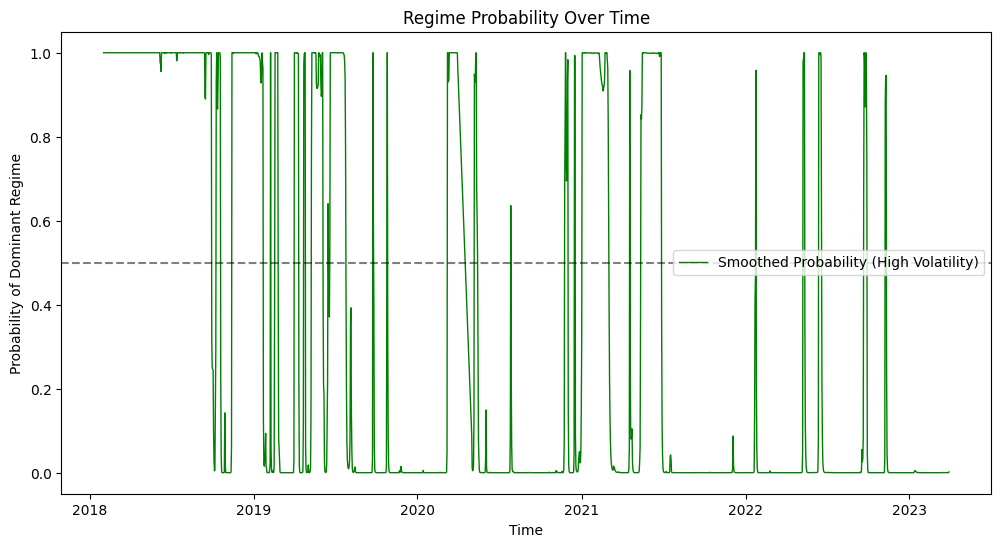

In [23]:
#scale data 
#features = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t','high', 'volume']
features = ['ln_RV_d,t','ln_RV_w,t', 'ln_RV_m,t','volume']#, 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

#X and y
X = data_scaled
y = data['target']


# Fit Hidden Markov Model (HMM) for Regime Classification
n_states = 2  # High and Low volatility regimes
hmm = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100000, init_params='', params="stmc", random_state=10)
hmm.fit(X)

# Predict regimes and regime probabilities
data['Regime'] = hmm.predict(X)
# Predict regime probabilities for high volatility state
data['Regime_Prob'] = hmm.predict_proba(X)[:, hmm.means_.argmax(axis=0)]

# Ensure regimes are ordered correctly (High volatility should have higher mean RV)
mean_rv_per_state = data.groupby('Regime')['ln_RV_d,t'].mean()
high_vol_regime = mean_rv_per_state.idxmax()
low_vol_regime = mean_rv_per_state.idxmin()

# Map regimes to labels
def map_regime(regime):
    return 'High Volatility' if regime == high_vol_regime else 'Low Volatility'

data['Regime'] = data['Regime'].map(map_regime)

# Plot the regimes
plt.figure(figsize=(12,6))
plt.plot(data.index, np.exp(data['ln_RV_d,t']), label='Log Realized Volatility', color='black', alpha=0.6)
plt.scatter(data.index, np.exp(data['ln_RV_d,t']), c=data['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'}), label='Regime', marker='o', alpha=0.6)
plt.legend()
plt.title("Bitcoin Volatility Regimes")
plt.xlabel("Time")
plt.ylabel("Log Realized Volatility")
plt.show()

# Plot regime probabilities
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Regime_Prob'], label='Smoothed Probability (High Volatility)', color='green', linewidth=1)

plt.axhline(0.5, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.title("Regime Probability Over Time")
plt.xlabel("Time")
plt.ylabel("Probability of Dominant Regime")
plt.show()


now we want to perform a stratified time series split. We choose strict chronological boundaries between train and test set to prevent train-test overlap

Train Regime Counts:
Low Volatility     888
High Volatility    390
Name: Regime, dtype: int64

Test Regime Counts:
Low Volatility     393
High Volatility    183
Name: Regime, dtype: int64


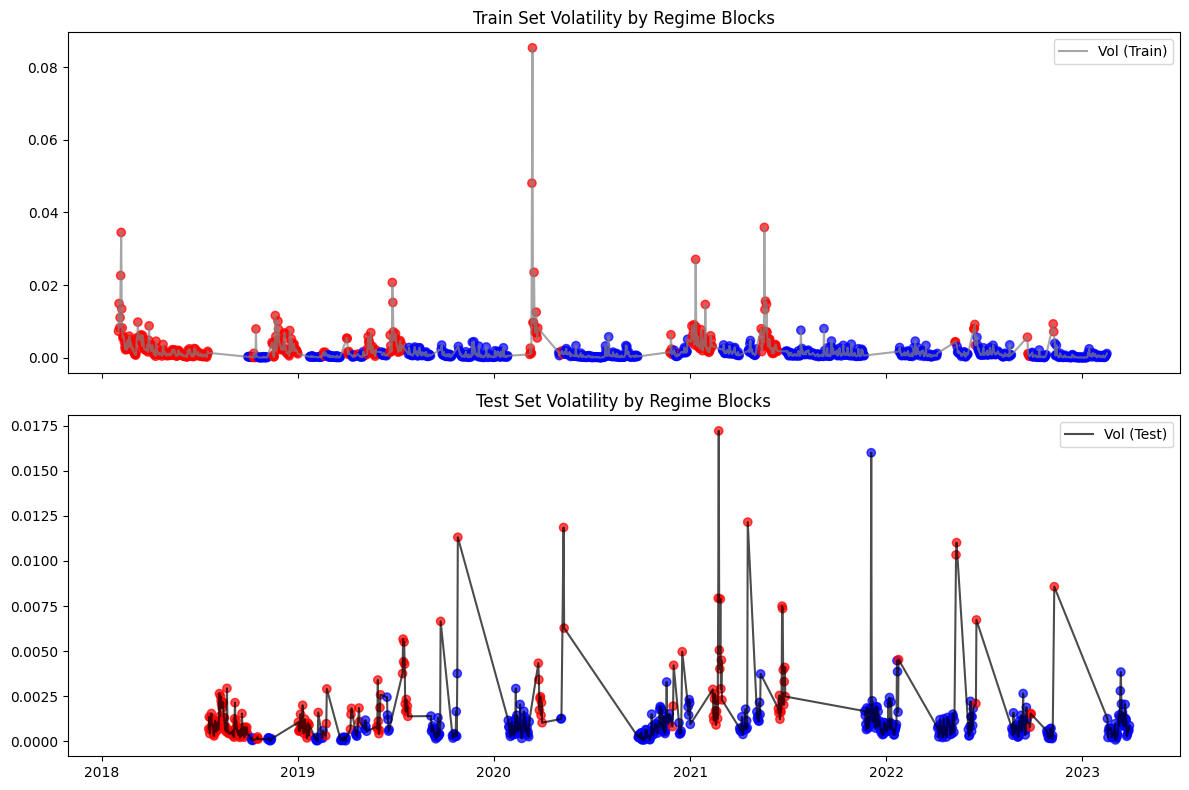

Train Regime Counts:
Low Volatility     896
High Volatility    401
Name: Regime, dtype: int64

Test Regime Counts:
Low Volatility     385
High Volatility    172
Name: Regime, dtype: int64


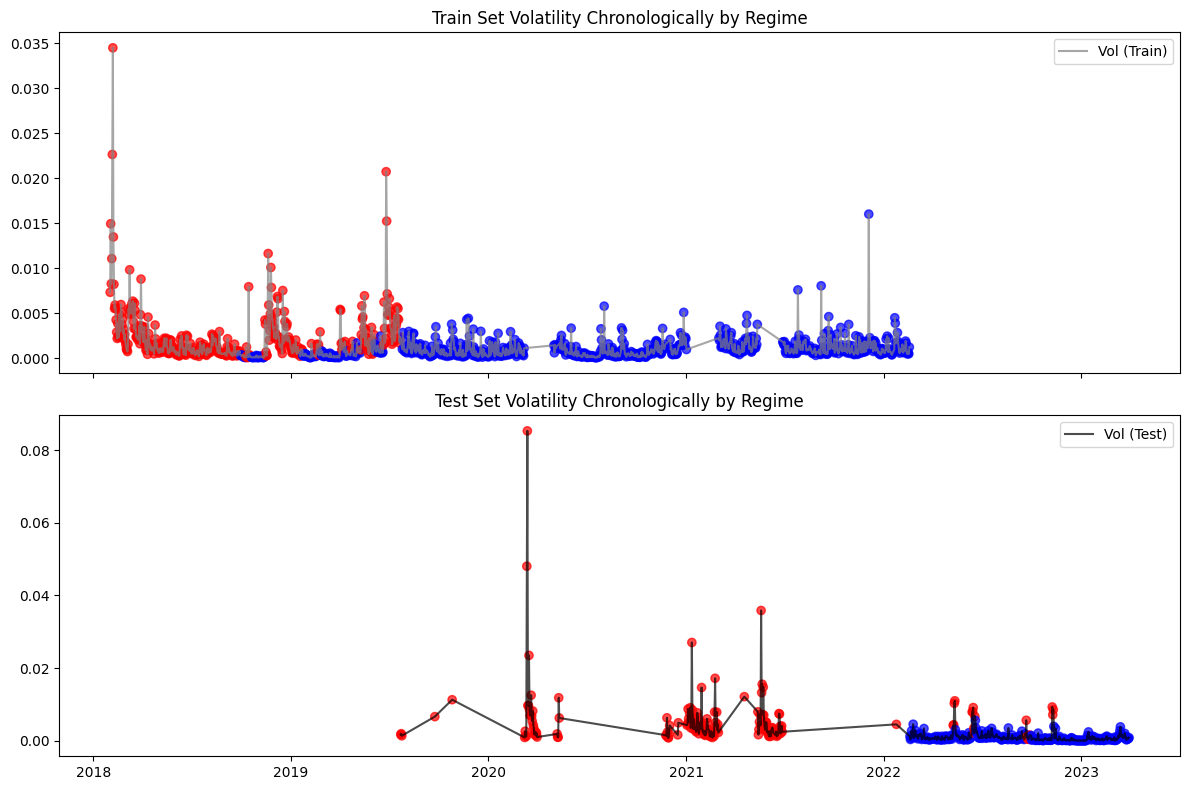

In [ ]:
import pandas as pd
import numpy as np

def find_regime_blocks(df, regime_col="Regime"):
    """
    Identify consecutive blocks of the same regime in a time-sorted DataFrame.
    Returns a list of (start_idx, end_idx, regime_label).
    """
    blocks = []
    start_idx = 0
    current_regime = df[regime_col].iloc[0]

    for i in range(1, len(df)):
        if df[regime_col].iloc[i] != current_regime:
            # We reached the end of a block
            blocks.append((start_idx, i-1, current_regime))
            start_idx = i
            current_regime = df[regime_col].iloc[i]

    # Last block goes till the end
    blocks.append((start_idx, len(df)-1, current_regime))
    return blocks

def stratified_time_split_by_blocks(df, regime_col="Regime", train_ratio=0.8):
    """
    Splits each consecutive regime block by time, 
    returning a combined train/test DataFrame with no reordering of time.
    """
    # 1) Identify consecutive regime blocks
    blocks = find_regime_blocks(df, regime_col=regime_col)
    
    # 2) Create containers for train / test
    train_dfs = []
    test_dfs = []
    
    for (start_idx, end_idx, block_regime) in blocks:
        # Subset for this block
        block_df = df.iloc[start_idx:end_idx+1]
        
        # Chronological split
        block_size = len(block_df)
        split_idx = int(block_size * train_ratio)
        
        block_train = block_df.iloc[:split_idx].copy()
        block_test = block_df.iloc[split_idx:].copy()
        
        # Append to respective containers
        train_dfs.append(block_train)
        test_dfs.append(block_test)
    
    # 3) Combine them in time order
    # Since blocks are in ascending time, just concat in the original order
    train_df = pd.concat(train_dfs)
    test_df = pd.concat(test_dfs)

    # Sort them by index just to be safe (should already be in order)
    train_df = train_df.sort_index()
    test_df = test_df.sort_index()
    
    return train_df, test_df

def stratified_time_split_total(df, regime_col="Regime", train_ratio=0.8):
    """
    1) Separate data by regime (e.g., 'High Volatility' and 'Low Volatility').
    2) Sort each subset by time (index).
    3) Perform a single chronological split at train_ratio for each regime subset.
    4) Concatenate the train subsets across regimes -> final train set.
       Concatenate the test subsets across regimes -> final test set.
    5) Sort the final train/test sets by index.

    Note: This approach ensures each regime has 80/20 coverage,
          but does NOT guarantee that the final train set is strictly earlier
          in time than the final test set across different regimes.
    """
    # Separate data by regime
    unique_regimes = df[regime_col].unique()
    
    # Storage for train/test subsets
    trains = []
    tests = []
    
    for reg in unique_regimes:
        # Subset for this regime
        subset = df[df[regime_col] == reg].copy()
        # Sort by index to ensure chronological
        subset = subset.sort_index()
        
        # Chronological split for this regime
        n = len(subset)
        split_idx = int(n * train_ratio)
        
        subset_train = subset.iloc[:split_idx]
        subset_test = subset.iloc[split_idx:]
        
        trains.append(subset_train)
        tests.append(subset_test)
    
    # Combine all regime-based subsets into final train/test
    train_df = pd.concat(trains).sort_index()
    test_df = pd.concat(tests).sort_index()
    
    return train_df, test_df


    
import matplotlib.pyplot as plt

# --------------------------
# 0) Assume we have 'data' with these columns:
#    data['Regime'] = {'High Volatility'/'Low Volatility'} # already assigned 
#    data is sorted by date index

train_df, test_df = stratified_time_split_by_blocks(data, regime_col="Regime", train_ratio=0.7)

# Check how many observations per regime in train/test
print("Train Regime Counts:")
print(train_df['Regime'].value_counts())

print("\nTest Regime Counts:")
print(test_df['Regime'].value_counts())

# Plot distribution
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)

# Plot the train set
ax[0].plot(train_df.index, np.exp(train_df['ln_RV_d,t']), label='Vol (Train)', color='gray', alpha=0.7)
colors_train = train_df['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
ax[0].scatter(train_df.index, np.exp(train_df['ln_RV_d,t']), c=colors_train, alpha=0.7, marker='o')
ax[0].set_title("Train Set Volatility by Regime Blocks")
ax[0].legend()

# Plot the test set
ax[1].plot(test_df.index, np.exp(test_df['ln_RV_d,t']), label='Vol (Test)', color='black', alpha=0.7)
colors_test = test_df['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
ax[1].scatter(test_df.index, np.exp(test_df['ln_RV_d,t']), c=colors_test, alpha=0.7, marker='o')
ax[1].set_title("Test Set Volatility by Regime Blocks")
ax[1].legend()

plt.tight_layout()
plt.show()


train_df, test_df = stratified_time_split_total(data, regime_col="Regime", train_ratio=0.7)

# Check how many observations per regime in train/test
print("Train Regime Counts:")
print(train_df['Regime'].value_counts())

print("\nTest Regime Counts:")
print(test_df['Regime'].value_counts())

# Plot distribution
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)

# Plot the train set
ax[0].plot(train_df.index, np.exp(train_df['ln_RV_d,t']), label='Vol (Train)', color='gray', alpha=0.7)
colors_train = train_df['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
ax[0].scatter(train_df.index, np.exp(train_df['ln_RV_d,t']), c=colors_train, alpha=0.7, marker='o')
ax[0].set_title("Train Set Volatility Chronologically by Regime")
ax[0].legend()

# Plot the test set
ax[1].plot(test_df.index, np.exp(test_df['ln_RV_d,t']), label='Vol (Test)', color='black', alpha=0.7)
colors_test = test_df['Regime'].map({'High Volatility': 'red', 'Low Volatility': 'blue'})
ax[1].scatter(test_df.index, np.exp(test_df['ln_RV_d,t']), c=colors_test, alpha=0.7, marker='o')
ax[1].set_title("Test Set Volatility Chronologically by Regime")
ax[1].legend()

plt.tight_layout()
plt.show()


In [18]:
#save data
train_df.to_csv('../data/train.csv')
test_df.to_csv('../data/test.csv')
data.to_csv('../data/data.csv')